<h1>mediapy &mdash; Read/write/show images and videos in an IPython/Jupyter notebook</h1>

[**[GitHub source]**](https://github.com/google/mediapy) &nbsp;
[**[API docs]**](https://google.github.io/mediapy/) &nbsp;
[**[PyPI package]**](https://pypi.org/project/mediapy/) &nbsp;
[**[Colab example]**](https://colab.research.google.com/github/google/mediapy/blob/main/mediapy_examples.ipynb)



### Setup

In [34]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

import itertools
import math

import mediapy as media
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
DATA_DIR = 'https://github.com/hhoppe/data/raw/main/'  # Or any local path.
IMAGE = DATA_DIR + 'image.png'
VIDEO = DATA_DIR + 'video.mp4'

### Image examples

""

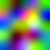

In [ ]:
# Display an image (a 2D or 3D numpy array):
np.random.seed(1)
image1 = media.resize_image(np.random.rand(5, 5, 3), (50, 50))
media.show_image(image1, border=True)

A title

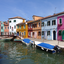

In [ ]:
# Read, resize, and display an image:
image2 = media.read_image(IMAGE)
image2 = media.resize_image(image2, (64, 64))
media.show_image(image2, title='A title')

checkerboard,darker noise,as YCbCr,as YUV,rotated,thresholded

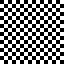
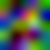
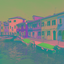
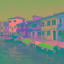
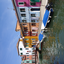
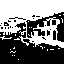

In [ ]:
# Show titled images side-by-side:
images = {
    'checkerboard': np.kron([[0, 1] * 8, [1, 0] * 8] * 8, np.ones((4, 4))),
    'darker noise': image1 * 0.7,
    'as YCbCr': media.ycbcr_from_rgb(image2),
    'as YUV': media.yuv_from_rgb(image2),
    'rotated': np.rot90(image2),
    'thresholded': (media.yuv_from_rgb(image2)[..., 0] > 0.5),
}
media.show_images(images, vmin=0.0, vmax=1.0, border=True, height=100)

""

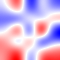

In [ ]:
# Show a scalar image using a color map:
np.random.seed(1)
image3 = media.resize_image(np.random.rand(5, 5) - 0.5, (60, 60))
media.show_image(image3, cmap='bwr', border=True)

gray,"[0, 1]",bwr,jet,"jet [0, 0.5]",radial

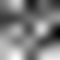
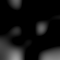
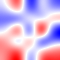
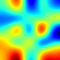
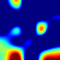
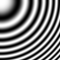

In [ ]:
# More examples of color maps and value bounds:
images = {
    'gray': image3,
    '[0, 1]': media.to_rgb(image3, vmin=0.0, vmax=1.0),
    'bwr': media.to_rgb(image3, cmap='bwr'),
    'jet': media.to_rgb(image3, cmap='jet'),
    'jet [0, 0.5]': media.to_rgb(image3, vmin=0.0, vmax=0.5, cmap='jet'),
    'radial': np.cos(((np.indices((60, 60)).T / 10)**2).sum(axis=-1)),
}
media.show_images(images, border=True, height=100)

In [ ]:
# Write an image to a file:
media.write_image('/tmp/image3.png', image3)

### Video examples

In [ ]:
# Display a video (a 3D or 4D array, or an iterable of images):
video1 = media.moving_circle((65, 65), num_images=10)
media.show_video(video1, fps=2)

""

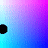

In [ ]:
# Show a video as a GIF, so that it is visible in the GitHub notebook preview:
media.show_video(1.0 - video1, height=48, codec='gif', fps=4)


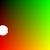
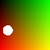
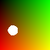
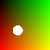
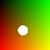
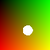
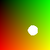
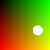
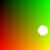
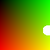

In [ ]:
# Show video frames side-by-side:
media.show_images(video1, columns=6, border=True, height=50)

0,1,2,3,4,5,6,7,8,9

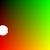
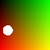
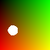
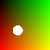
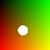
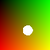
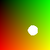
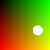
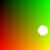
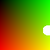

In [ ]:
# Show the frames with their indices:
media.show_images({f'{i}': image for i, image in enumerate(video1)}, width=50)

Shape is (num_images, height, width, num_channels) = (10, 180, 320, 3).
Framerate is 30.0 frames/s.


""

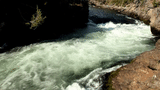

In [ ]:
# Read, resize, and display a video:
video2 = media.read_video(VIDEO)
print(f'Shape is (num_images, height, width, num_channels) = {video2.shape}.')
print(f'Framerate is {video2.metadata.fps} frames/s.')
video2 = media.resize_video(video2, np.array(video2.shape[1:3]) // 2)
media.show_video(video2, fps=5, codec='gif')

""

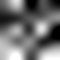

In [ ]:
# Display a two-frame flipping video as a GIF:
media.show_video([image3 + 0.5, (image3 + 0.5) * 0.8], fps=2, codec='gif')

In [ ]:
# Darken a video frame-by-frame:
new_file = '/tmp/out.mp4'
with media.VideoReader(VIDEO) as reader:
  print(f'num_images={reader.num_images} shape={reader.shape} fps={reader.fps}')
  darken_image = lambda image: media.to_float01(image) * 0.5
  with media.VideoWriter(
      new_file, shape=reader.shape, fps=reader.fps / 5,
      bps=reader.bps / 5) as writer:
    for image in reader:
      writer.add_image(darken_image(image))
media.show_video(media.read_video(new_file), height=90)

num_images=10 shape=(180, 320) fps=30.0


In [ ]:
# Show multiple videos side-by-side.
s = 90
videos = {
    'mirror loop': np.concatenate([video2, video2[::-1]], axis=0),
    'roll': (np.roll(media.color_ramp((s, s)), i, axis=0) for i in range(s)),
    'fade': (np.full((s, s), f) for f in np.linspace(0.0, 1.0, 50)),
}
media.show_videos(videos, fps=5)

"fade <source src=""data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAABDZtZGF0AAAAMgYFLtxF6b3m2Ui3lizYINkj7u94MjY0IC0gY29yZSAxNTUgcjI5MDEgN2QwZmYyMgCAAAAAJWWIhAD//vSg+BTQYmPKzFa92IiR0U0gF1CHyE3oW9HZniAUs5cAAAAsQZohZYJgCAn/X8v+wPSeFoRpKQdhMZlpb17tiSVOIdgODcpulQHpXlAMMKAAAAAVQZpCSeEIQyCMDMCJAzAgA//kQFtBAAAAFEGaZEvhCEPIbAtNAtFAU//kQFtAAAAACAGeg2pJ/xFxAAAAFUGahkvhCEPIfAQw5AQwwBT/5EBbQQAAAAgBnqVqSf8RcQAAABVBmqhL4QhDyHwEUMQEUKAU/+RAW0EAAAAIAZ7Hakn/EXAAAAAVQZrKS+EIQ8h8BHGQEcQBT//kQFtAAAAACAGe6WpJ/xFxAAAAFEGa7EvhCEPIbAjGQIxAFP/kQFtAAAAACAGfC2pJ/xFwAAAAFUGbDkvhCEPIbAhDkCEMAU//5EBbQQAAAAgBny1qSf8RcQAAABVBmzBL4QhDyGwIQ5AhDAFP/+RAW0EAAAAIAZ9Pakn/EXAAAAAVQZtSS+EIQ8hsCEMQIQoBT//kQFtAAAAACAGfcWpJ/xFxAAAAFUGbdEvhCEPIfAQQ5AQQwBT/5EBbQAAAAAgBn5NqSf8RcAAAABVBm5ZL4QhDyHwEEOQEEMAU/+RAW0EAAAAIAZ+1akn/EXAAAAAVQZu4S+EIQ8h8BBDkBBDAFP/kQFtBAAAACAGf12pJ/xFxAAAAFUGb2kvhCEPIfA/BZA/BQBT/5EBbQAAAAAgBn/lqSf8RcQAAABVBm/xL4QhDyHwEEOQEEMAU/+RAW0AAAAAIAZ4bakn/EXEAAAAVQZoeS+EIQ8h8D8FkD8FAFP/kQFtBAAAACAGePWpJ/xFwAAAAFUGaIEvhCEPIfA/BZA/BQBT/5EBbQAAAAAgBnl9qSf8RcQAAABVBmkJL4QhDyHwPwWQPwUAU/+RAW0AAAAAIAZ5hakn/EXEAAAAVQZpkS+EIQ8h8D8GED8FgFP/kQFtAAAAACAGeg2pJ/xFxAAAAFUGahUvhCEPIXFAPxFAPoA//5EBbQQAAABJBmqdJ4Q8jxwBAQFET/+RAW0EAAAAIAZ7Gakn/EXEAAAASQZrJSeEPIbA3AEBAU//kQFtAAAAACAGe6GpJ/xFwAAAAFkGa6kvhCEPIbA1AP9A1AEBAP+RAW0EAAAAVQZsLS+EIQ8hMUAokUAoAD//kQFtAAAAAFkGbLEvhCEPIbAzAO9AzAPEA/+RAW0AAAAAXQZtPS+EIQ8gjAXQCQQF0AjgD/+RAW0EAAAAJQZ9tRRE9fw75AAAACAGfjmpJ/xFxAAAAF0GbkEuoQhBaIbArAJNArAJUA//kQFtAAAAAFkGbsUvhCEKUh8DMBmQMwGQA/+RAW0AAAAU0bW9vdgAAAGxtdmhkAAAAAAAAAAAAAAAAAAAD6AAAJxAAAQAAAQAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAABGV0cmFrAAAAXHRraGQAAAADAAAAAAAAAAAAAAABAAAAAAAAJxAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAAFoAAABaAAAAAAAkZWR0cwAAABxlbHN0AAAAAAAAAAEAACcQAAAQAAABAAAAAAPdbWRpYQAAACBtZGhkAAAAAAAAAAAAAAAAAAAoAAABkABVxAAAAAAALWhkbHIAAAAAAAAAAHZpZGUAAAAAAAAAAAAAAABWaWRlb0hhbmRsZXIAAAADiG1pbmYAAAAUdm1oZAAAAAEAAAAAAAAAAAAAACRkaW5mAAAAHGRyZWYAAAAAAAAAAQAAAAx1cmwgAAAAAQAAA0hzdGJsAAAAmHN0c2QAAAAAAAAAAQAAAIhhdmMxAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAFoAWgBIAAAASAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGP//AAAAMmF2Y0MBZAAK/+EAGWdkAAqs2UY3kkhAAAADAEAAAAMCg8SJZYABAAZo6+GyyLAAAAAYc3R0cwAAAAAAAAABAAAAMgAACAAAAAAUc3RzcwAAAAAAAAABAAAAAQAAAXBjdHRzAAAAAAAAACwAAAADAAAQAAAAAAEAABgAAAAAAQAACAAAAAABAAAYAAAAAAEAAAgAAAAAAQAAGAAAAAABAAAIAAAAAAEAABgAAAAAAQAACAAAAAABAAAYAAAAAAEAAAgAAAAAAQAAGAAAAAABAAAIAAAAAAEAABgAAAAAAQAACAAAAAABAAAYAAAAAAEAAAgAAAAAAQAAGAAAAAABAAAIAAAAAAEAABgAAAAAAQAACAAAAAABAAAYAAAAAAEAAAgAAAAAAQAAGAAAAAABAAAIAAAAAAEAABgAAAAAAQAACAAAAAABAAAYAAAAAAEAAAgAAAAAAQAAGAAAAAABAAAIAAAAAAEAABgAAAAAAQAACAAAAAABAAAYAAAAAAEAAAgAAAAAAQAAEAAAAAABAAAYAAAAAAEAAAgAAAAAAQAAGAAAAAABAAAIAAAAAAMAABAAAAAAAQAAIAAAAAACAAAIAAAAAAIAABAAAAAAHHN0c2MAAAAAAAAAAQAAAAEAAAAyAAAAAQAAANxzdHN6AAAAAAAAAAAAAAAyAAAAXwAAADAAAAAZAAAAGAAAAAwAAAAZAAAADAAAABkAAAAMAAAAGQAAAAwAAAAYAAAADAAAABkAAAAMAAAAGQAAAAwAAAAZAAAADAAAABkAAAAMAAAAGQAAAAwAAAAZAAAADAAAABkAAAAMAAAAGQAAAAwAAAAZAAAADAAAABkAAAAMAAAAGQAAAAwAAAAZAAAADAAAABkAAAAWAAAADAAAABYAAAAMAAAAGgAAABkAAAAaAAAAGwAAAA0AAAAMAAAAGwAAABoAAAAUc3RjbwAAAAAAAAABAAAAMAAAAFt1ZHRhAAAAU21ldGEAAAAAAAAAIWhkbHIAAAAAAAAAAG1kaXJhcHBsAAAAAAAAAAAAAAAAJmlsc3QAAAAeqXRvbwAAABZkYXRhAAAAAQAAAABHb29nbGU="" type=""video/mp4""/> This browser does not support the video tag."


In [ ]:
# Write a video to a file:
media.write_video('/tmp/video1.mp4', video1, fps=10, qp=10)

### Conway's Game of Life

Cellular automaton implemented on a periodic domain.
See [Wikipedia](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life).

Show the first 16 generations starting from a random configuration:

""

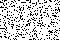

In [35]:
def game_of_life(shape=(40, 60), seed=1):
  np.random.seed(seed)
  grid = (np.random.random(shape) < 0.2).astype(np.int32)
  NEIGHBORS = set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)}
  while True:
    yield grid == 0
    num_neighbors = np.add.reduce([
        np.roll(grid, yx, axis=(0, 1)) for yx in NEIGHBORS])
    grid = (num_neighbors == 3) | (grid & (num_neighbors == 2))

media.show_video(itertools.islice(game_of_life(), 16),
                 height=160, fps=8, codec='gif', border=True)

Show the 100<sup>th</sup> generation starting from different random seeds:

seed=0,seed=1,seed=2,seed=3,seed=4
seed=5,seed=6,seed=7,seed=8,seed=9

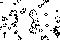
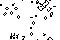
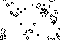
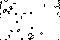
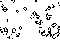
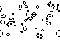
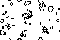
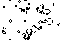
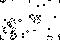
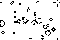

In [38]:
images = {
    f'seed={seed}': next(itertools.islice(game_of_life(seed=seed), 100, None))
    for seed in range(10)
}
media.show_images(images, border=True, columns=5, height=80)

### Mandelbrot Set

Visualize divergence of $\|z_i\|$ in the sequence $z_0 = 0,~z_{i+1} = z_{i}^2 + c$ over complex numbers $c$.
See [Wikipedia](https://en.wikipedia.org/wiki/Mandelbrot_set).

""

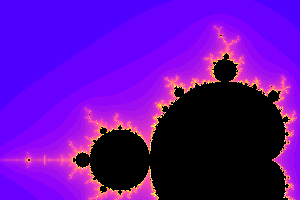

In [ ]:
def mandelbrot(shape, center_xy=(-0.75, -0.5), radius=1.25, max_iter=200):
  yx = np.moveaxis(np.indices(shape), 0, -1)
  yx = (yx + 0.5 - np.array(shape) / 2) / max(shape) * 2  # in [-1, 1]^2
  c = np.dot(yx * radius + center_xy[::-1], (1j, 1))
  count_iter = np.zeros(shape)
  z = np.zeros_like(c)
  for it in range(max_iter):
    active = np.abs(z) < 4
    count_iter[active] = it
    z[active] = z[active]**2 + c[active]
  return np.where(active, 0, count_iter)

media.show_image(mandelbrot((200, 300))**0.23, cmap='gnuplot2')

### Format conversions

In [ ]:
def apply_conversions(image):
  assert image.dtype == np.uint8
  for dtype in ('uint8', 'uint16', 'uint32', 'uint64', 'float32', 'float64'):
    a = media.to_type(image, dtype)
    print(f'dtype={a.dtype!s:<8} mean={np.mean(a)}')
    assert np.all(media.to_uint8(a) == image)

apply_conversions(image2)

dtype=uint8    mean=121.61360677083333
dtype=uint16   mean=31254.696940104168
dtype=uint32   mean=2048339073.3636067
dtype=uint64   mean=8.797549333263974e+18
dtype=float32  mean=0.47691610455513
dtype=float64  mean=0.4769161049836601


### Image rate-distortion

jpeg,quality=10,quality=20,quality=40,quality=75,quality=90,quality=95,quality=100


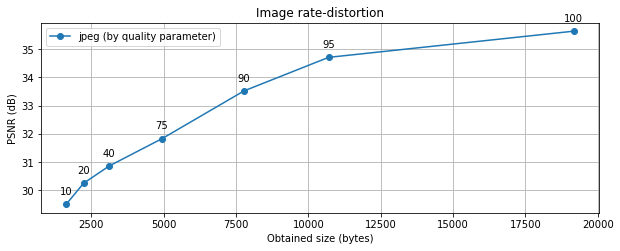

In [ ]:
def analyze_image_rate_distortion(image, fmt='jpeg'):
  params = [10, 20, 40, 75, 90, 95, 100]
  images = {}
  num_bytes, psnrs = [], []

  for param in params:
    data = media.compress_image(image, fmt=fmt, quality=param)
    num_bytes.append(len(data))
    image_new = media.decompress_image(data)
    images[f'quality={param}'] = image_new[30:60, 0:30]
    rms_error = np.sqrt(np.mean(np.square(image_new - image)))
    psnr = 20 * math.log10(255.0 / rms_error)
    psnrs.append(psnr)

  media.show_images(images, border=True, ylabel=fmt, height=120)
  fig, ax = plt.subplots(figsize=(10, 3.5))
  ax.plot(num_bytes, psnrs, 'o-', label=f'{fmt} (by quality parameter)')
  for x, y, param in zip(num_bytes, psnrs, params):
    kwargs = dict(textcoords='offset points', xytext=(0, 10), ha='center')
    plt.annotate(f'{param}', (x, y), **kwargs)
  ax.set_title('Image rate-distortion')
  ax.set_xlabel('Obtained size (bytes)')
  ax.set_ylabel('PSNR (dB)')
  ax.legend(), ax.grid(True)
  plt.show()

analyze_image_rate_distortion(media.read_image(IMAGE))  # or try fmt='webp'

### Video rate-distortion

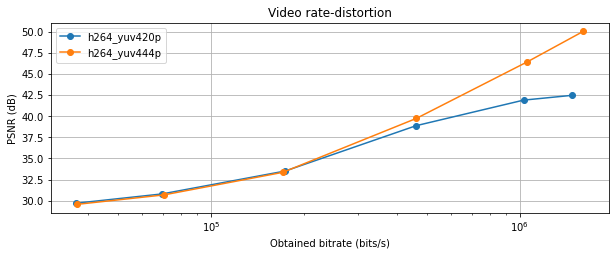

In [ ]:
# Note that the metadata in the video container may be a significant overhead
# for small videos; see https://superuser.com/questions/1617422/.

def analyze_video_rate_distortion(video, fps=30, codec='h264'):
  fig, ax = plt.subplots(figsize=(10, 3.5))

  for encoded_format in ['yuv420p', 'yuv444p']:
    bitrates, psnrs = [], []
    for requested_mbps in [0.03, 0.1, 0.3, 1, 3, 10]:
      bps = int(requested_mbps * 1.0e6)
      data = media.compress_video(
          video, encoded_format=encoded_format, codec=codec, bps=bps, fps=fps)
      video_new = media.decompress_video(data)
      rms_error = np.sqrt(np.mean(np.square(video_new - video)))
      psnr = 20 * math.log10(255.0 / rms_error)
      obtained_bps = len(data) * 8 / (len(video) / fps)
      bitrates.append(obtained_bps)
      psnrs.append(psnr)
    ax.semilogx(bitrates, psnrs, 'o-', label=f'{codec}_{encoded_format}')

  ax.set_title('Video rate-distortion')
  ax.set_xlabel('Obtained bitrate (bits/s)')
  ax.set_ylabel('PSNR (dB)')
  ax.legend(), ax.grid(True)
  plt.show()

analyze_video_rate_distortion(video2)

### Epilogue